In [1]:
#13.2.1 오토인코더란

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt

import torchvision.datasets as datasets
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(
    root="../chap13/data", train=True, transform=transform, download=True)

test_dataset = datasets.MNIST(
    root="../chap13/data", train=False, transform=transform, download=True)

train_loader = DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=False)

test_loader = DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [4]:
class Encoder(nn.Module):    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        self.flatten = nn.Flatten(start_dim=1)
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
    
class Decoder(nn.Module):    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [5]:
encoder = Encoder(encoded_space_dim=4,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=4,fc2_input_dim=128)
encoder.to(device)
decoder.to(device)

params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=0.001, weight_decay=1e-05)
loss_fn = torch.nn.MSELoss()

In [6]:
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer,noise_factor=0.3):
    encoder.train()
    decoder.train()
    train_loss = []
    for image_batch, _ in dataloader: 
        image_noisy = add_noise(image_batch,noise_factor)
        image_noisy = image_noisy.to(device)    
        encoded_data = encoder(image_noisy)
        decoded_data = decoder(encoded_data)
        loss = loss_fn(decoded_data, image_noisy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)

In [7]:
def test_epoch(encoder, decoder, device, dataloader, loss_fn,noise_factor=0.3):
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): 
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            image_batch = image_batch.to(device)
            encoded_data = encoder(image_batch)
            decoded_data = decoder(encoded_data)
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [8]:
def add_noise(inputs,noise_factor=0.3):
    noisy = inputs+torch.randn_like(inputs) * noise_factor
    noisy = torch.clip(noisy,0.,1.)
    return noisy

In [9]:
from matplotlib import font_manager
font_fname = 'C:/Windows/Fonts/malgun.ttf'
font_family = font_manager.FontProperties(fname=font_fname).get_name()
plt.rcParams["font.family"] = font_family

In [10]:
def plot_ae_outputs(encoder,decoder,n=5,noise_factor=0.3):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
        ax = plt.subplot(3,n,i+1)
        img = test_dataset[i][0].unsqueeze(0)
        image_noisy = add_noise(img,noise_factor)     
        image_noisy = image_noisy.to(device)

        encoder.eval()
        decoder.eval()

        with torch.no_grad():
            rec_img  = decoder(encoder(image_noisy))

        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('원래 이미지')
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(image_noisy.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('노이즈가 적용되어 손상된 이미지')

        ax = plt.subplot(3, n, i + 1 + n + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('재구성된 이미지')
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.7, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)     
    plt.show() 


 EPOCH 1/30 	 train loss 0.089 	 val loss 0.051


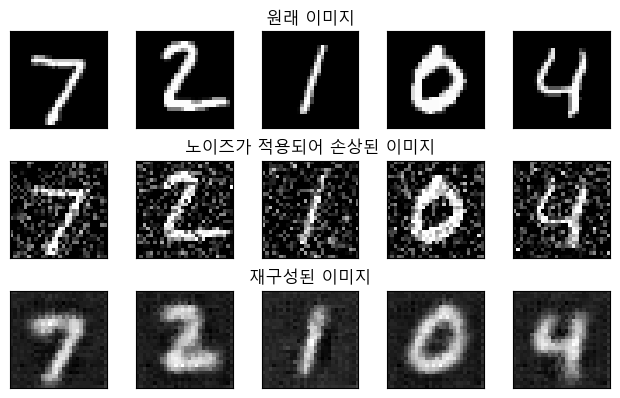


 EPOCH 2/30 	 train loss 0.055 	 val loss 0.045


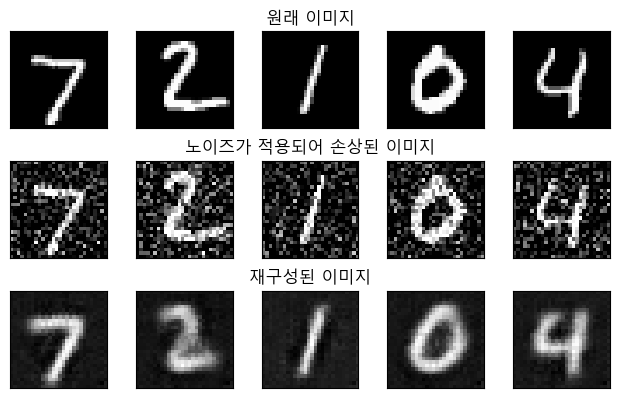


 EPOCH 3/30 	 train loss 0.053 	 val loss 0.043


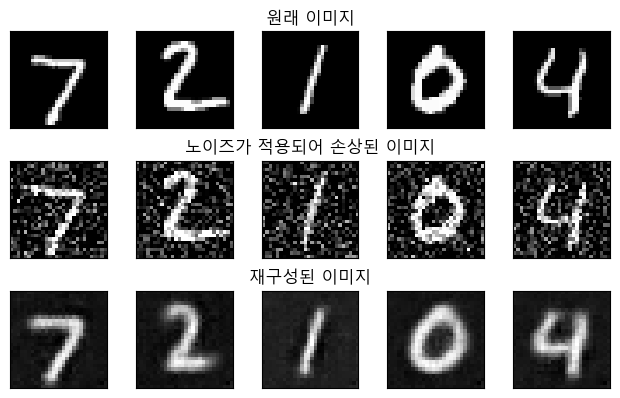


 EPOCH 4/30 	 train loss 0.052 	 val loss 0.042


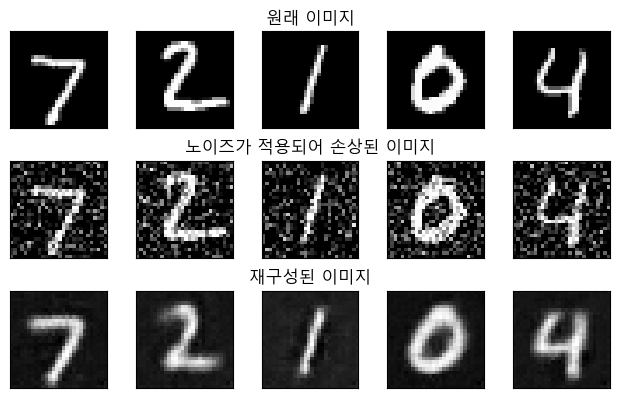


 EPOCH 5/30 	 train loss 0.052 	 val loss 0.041


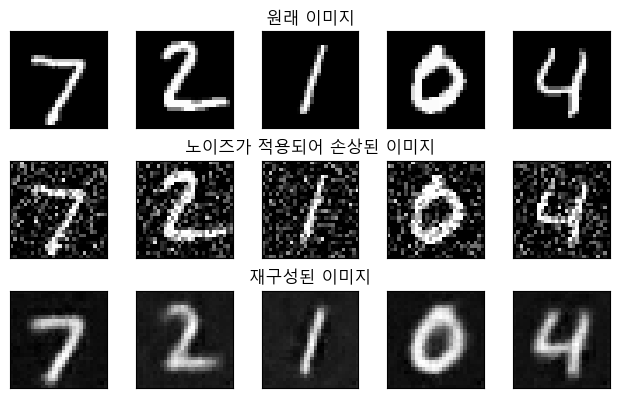


 EPOCH 6/30 	 train loss 0.051 	 val loss 0.041


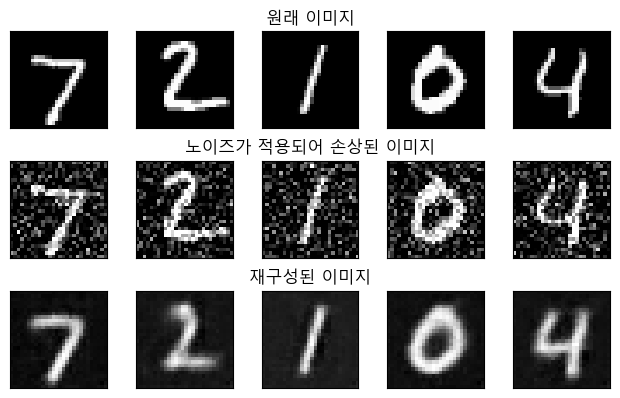


 EPOCH 7/30 	 train loss 0.051 	 val loss 0.040


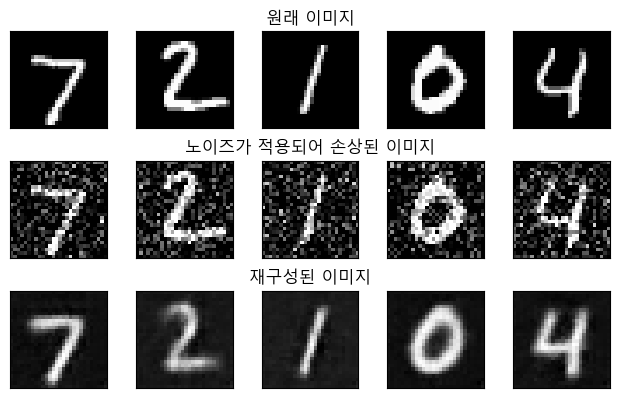


 EPOCH 8/30 	 train loss 0.051 	 val loss 0.040


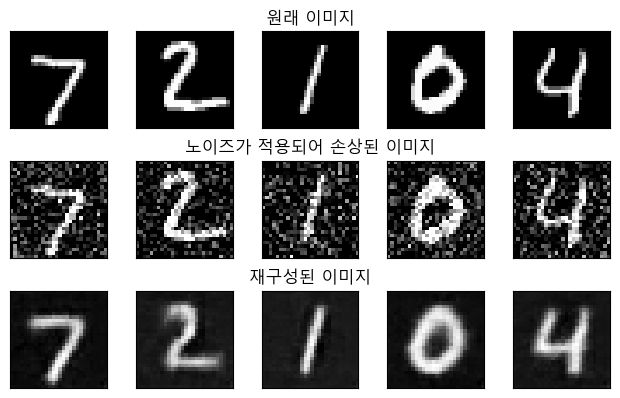


 EPOCH 9/30 	 train loss 0.051 	 val loss 0.040


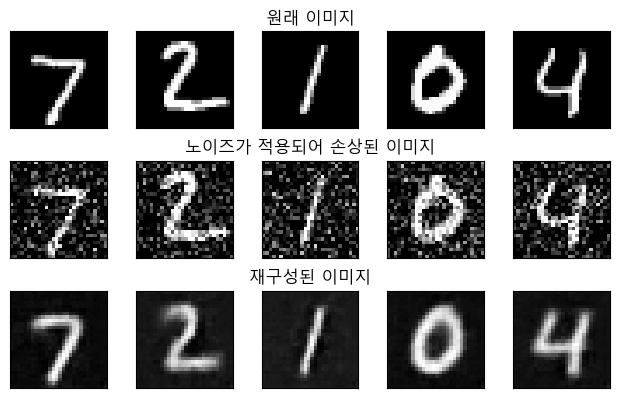


 EPOCH 10/30 	 train loss 0.051 	 val loss 0.040


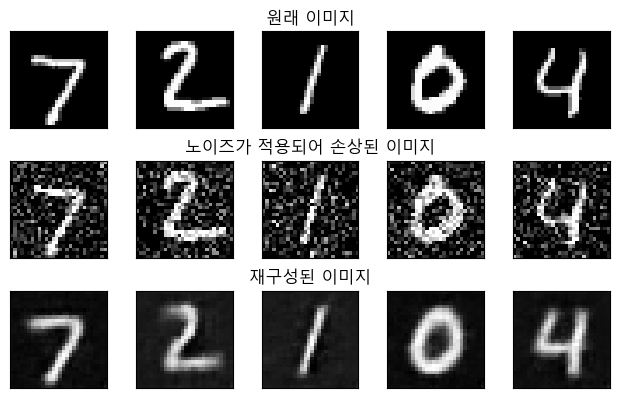


 EPOCH 11/30 	 train loss 0.050 	 val loss 0.039


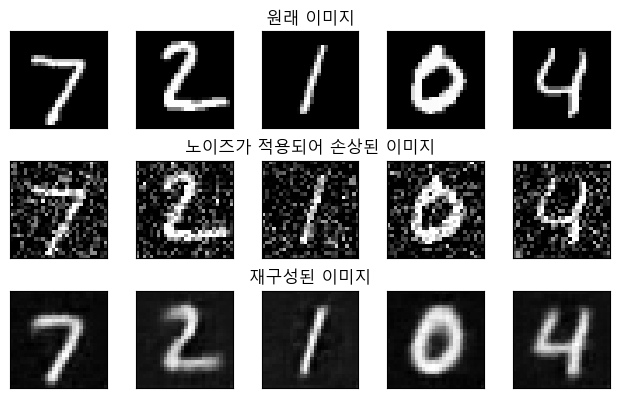


 EPOCH 12/30 	 train loss 0.050 	 val loss 0.039


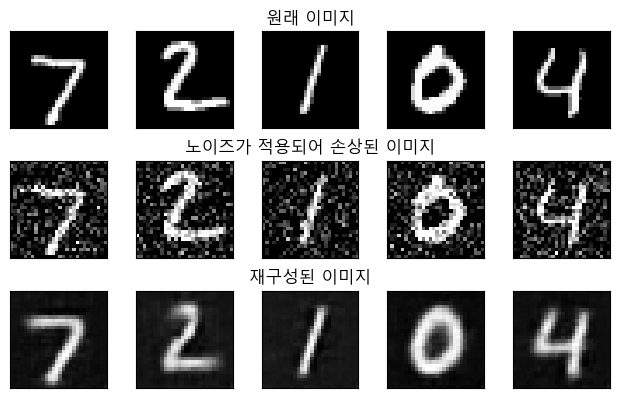


 EPOCH 13/30 	 train loss 0.050 	 val loss 0.039


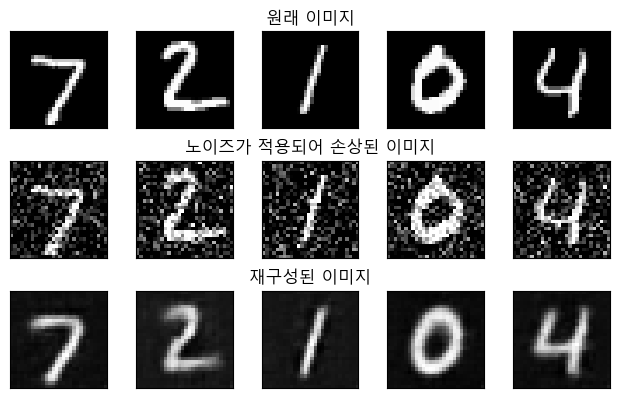


 EPOCH 14/30 	 train loss 0.050 	 val loss 0.039


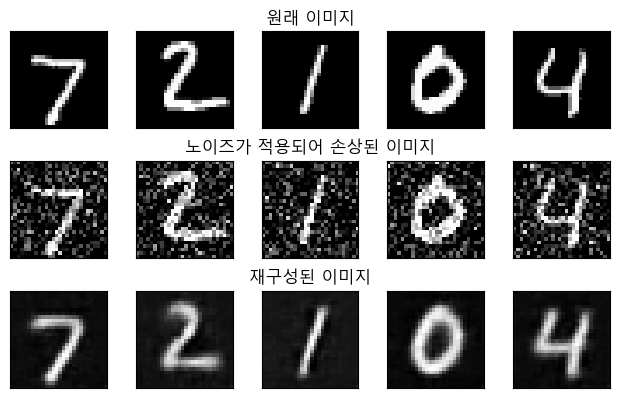


 EPOCH 15/30 	 train loss 0.050 	 val loss 0.039


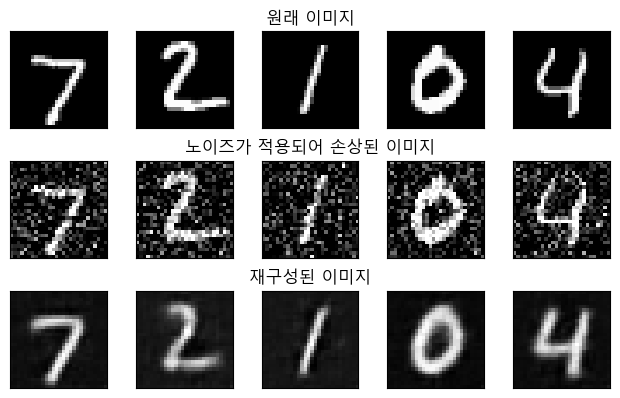


 EPOCH 16/30 	 train loss 0.050 	 val loss 0.038


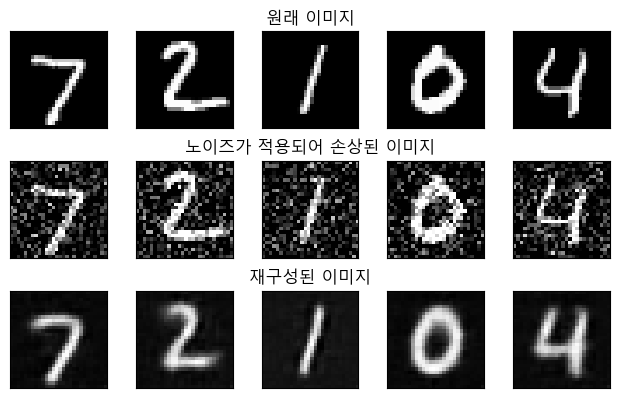


 EPOCH 17/30 	 train loss 0.050 	 val loss 0.039


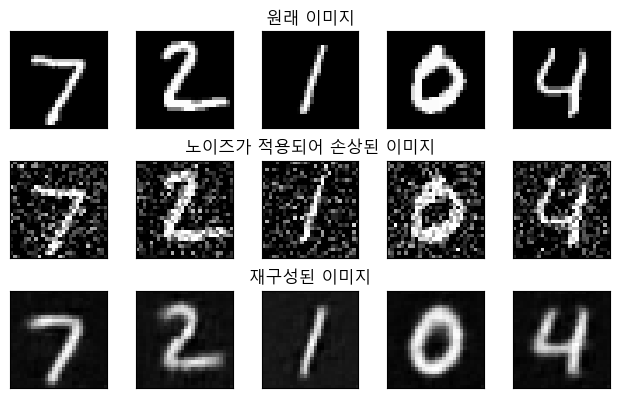


 EPOCH 18/30 	 train loss 0.050 	 val loss 0.039


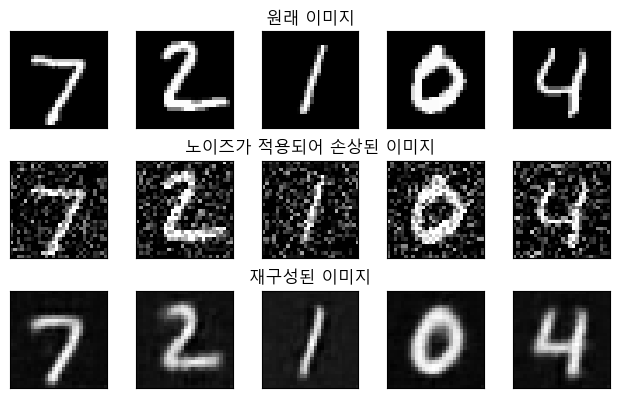


 EPOCH 19/30 	 train loss 0.050 	 val loss 0.038


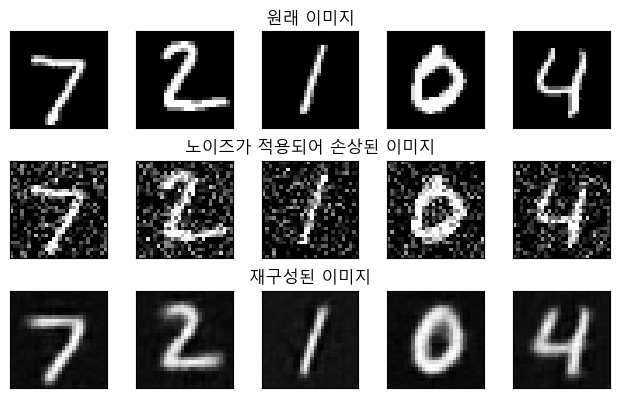


 EPOCH 20/30 	 train loss 0.050 	 val loss 0.038


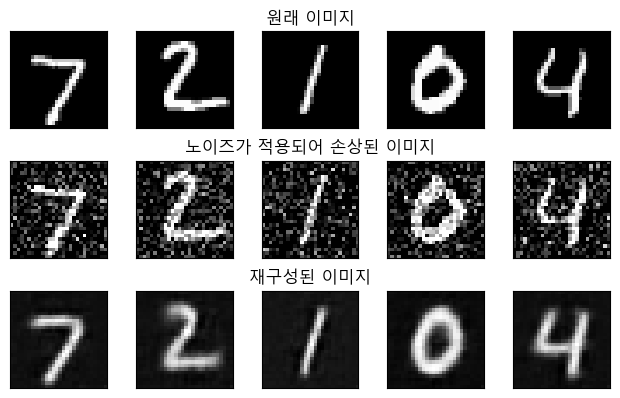


 EPOCH 21/30 	 train loss 0.050 	 val loss 0.039


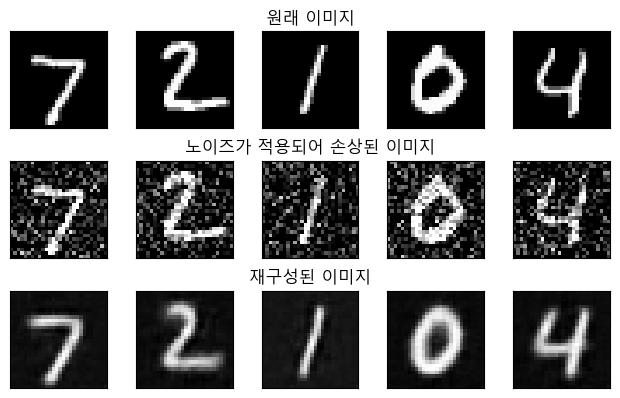


 EPOCH 22/30 	 train loss 0.050 	 val loss 0.038


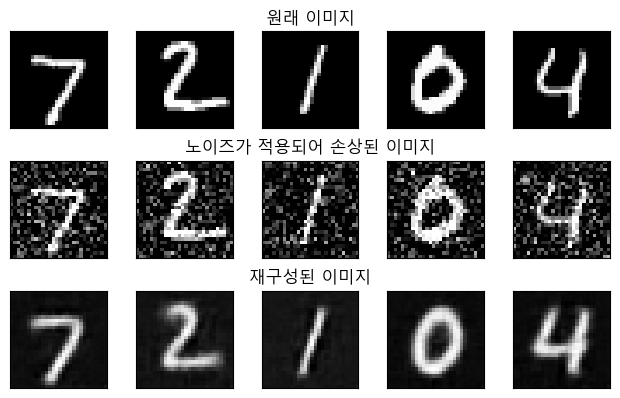


 EPOCH 23/30 	 train loss 0.050 	 val loss 0.038


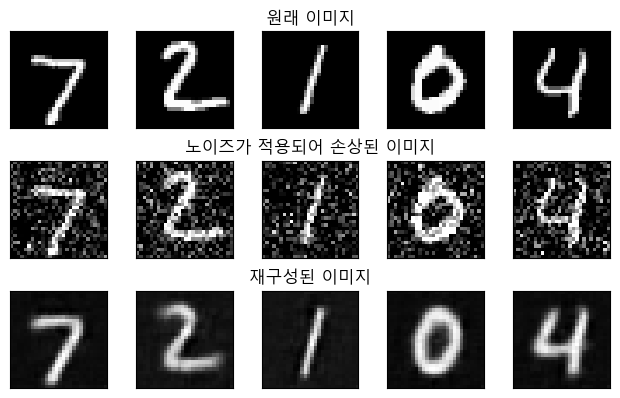


 EPOCH 24/30 	 train loss 0.050 	 val loss 0.038


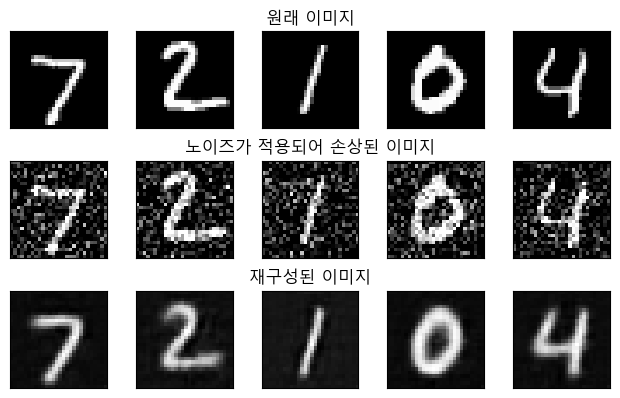


 EPOCH 25/30 	 train loss 0.050 	 val loss 0.038


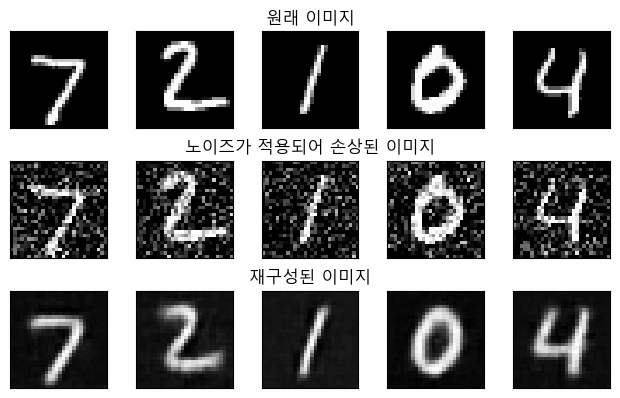


 EPOCH 26/30 	 train loss 0.049 	 val loss 0.038


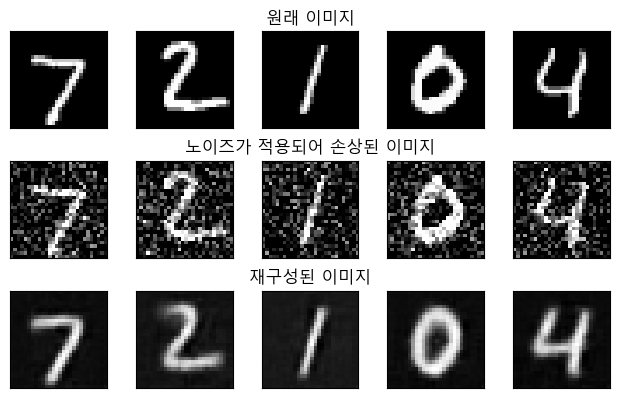


 EPOCH 27/30 	 train loss 0.049 	 val loss 0.038


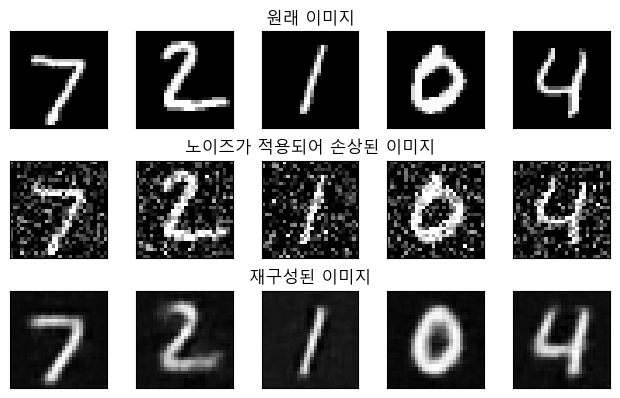


 EPOCH 28/30 	 train loss 0.049 	 val loss 0.038


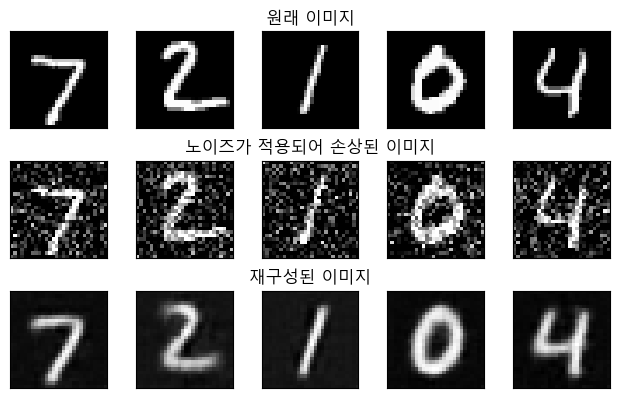


 EPOCH 29/30 	 train loss 0.049 	 val loss 0.038


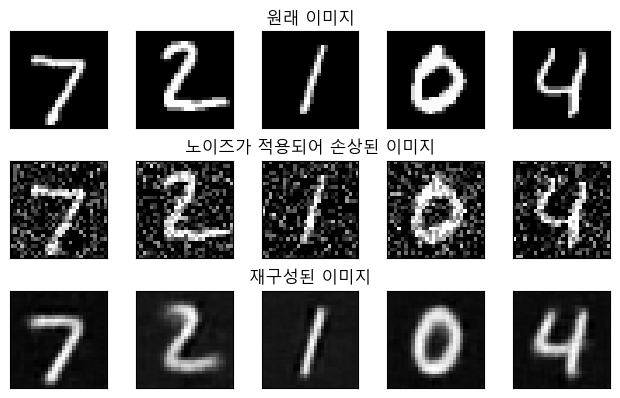


 EPOCH 30/30 	 train loss 0.049 	 val loss 0.037


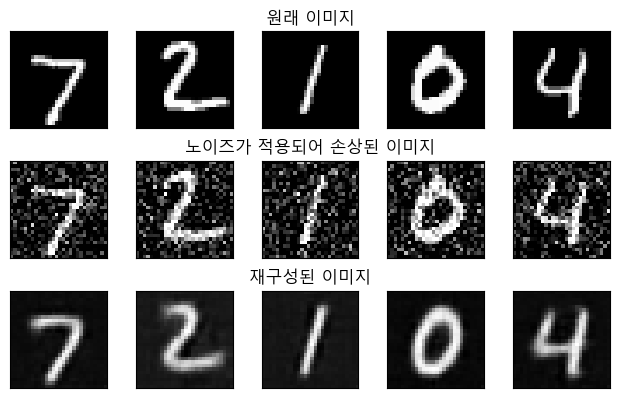

In [11]:
import numpy as np

num_epochs = 30
history_da={'train_loss':[],'val_loss':[]}
loss_fn = torch.nn.MSELoss()

for epoch in range(num_epochs):
    train_loss=train_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_loader, 
        loss_fn=loss_fn, 
        optimizer=optim, noise_factor=0.3)
    val_loss = test_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=test_loader, 
        loss_fn=loss_fn, noise_factor=0.3)
    history_da['train_loss'].append(train_loss)
    history_da['val_loss'].append(val_loss)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    plot_ae_outputs(encoder,decoder,noise_factor=0.3)

In [1]:
#13.2.2 변형 오토인코더(Variational AutoEncoder)

In [14]:
import datetime
import os
from tensorboardX import SummaryWriter

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt

import torchvision.datasets as datasets
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(
    root="../chap13/data", train=True, transform=transform, download=True)

test_dataset = datasets.MNIST(
    root="../chap13/data", train=False, transform=transform, download=True)

train_loader = DataLoader(
    train_dataset, batch_size=100, shuffle=True, num_workers=4, pin_memory=False)

test_loader = DataLoader(
    test_dataset, batch_size=100, shuffle=False, num_workers=4)

In [16]:
class Encoder(nn.Module):    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.input1 = nn.Linear(input_dim, hidden_dim)
        self.input2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, latent_dim)
        self.var = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)        
        self.training = True
        
    def forward(self, x):
        h_ = self.LeakyReLU(self.input1(x))
        h_ = self.LeakyReLU(self.input2(h_))
        mean = self.mean(h_)
        log_var = self.var(h_)                           
        return mean, log_var

In [17]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.hidden1 = nn.Linear(latent_dim, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h = self.LeakyReLU(self.hidden1(x))
        h = self.LeakyReLU(self.hidden2(h))        
        x_hat = torch.sigmoid(self.output(h))
        return x_hat

In [18]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)                
        z = mean + var*epsilon                          
        return z
                        
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) 
        x_hat = self.Decoder(z)        
        return x_hat, mean, log_var

In [19]:
x_dim  = 784
hidden_dim = 400
latent_dim = 200
epochs = 30
batch_size = 100

encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(device)

In [20]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss, KLD

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [21]:
saved_loc = 'scalar/'
writer = SummaryWriter(saved_loc)

model.train()
def train(epoch, model, train_loader, optimizer):
    train_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(device)

        optimizer.zero_grad()
        x_hat, mean, log_var = model(x)
        BCE, KLD = loss_function(x, x_hat, mean, log_var)
        loss = BCE + KLD
        writer.add_scalar("Train/Reconstruction Error", BCE.item(), batch_idx + epoch * (len(train_loader.dataset)/batch_size) )
        writer.add_scalar("Train/KL-Divergence", KLD.item(), batch_idx + epoch * (len(train_loader.dataset)/batch_size) )
        writer.add_scalar("Train/Total Loss" , loss.item(), batch_idx + epoch * (len(train_loader.dataset)/batch_size) )
        
        train_loss += loss.item()  
        loss.backward()
        optimizer.step()
          
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\t Loss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(x)))
            
    print("======> Epoch: {} Average loss: {:.4f}".format(
        epoch, train_loss / len(train_loader.dataset)))

In [22]:
def test(epoch, model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (x, _) in enumerate(test_loader):
            x = x.view(batch_size, x_dim)
            x = x.to(device)        
            x_hat, mean, log_var = model(x)
            BCE, KLD = loss_function(x, x_hat, mean, log_var)
            loss = BCE + KLD
        
            writer.add_scalar("Test/Reconstruction Error", BCE.item(), batch_idx + epoch * (len(test_loader.dataset)/batch_size) )
            writer.add_scalar("Test/KL-Divergence", KLD.item(), batch_idx + epoch * (len(test_loader.dataset)/batch_size) )
            writer.add_scalar("Test/Total Loss" , loss.item(), batch_idx + epoch * (len(test_loader.dataset)/batch_size) )
            test_loss += loss.item()

            if batch_idx == 0:
                n = min(x.size(0), 8)
                comparison = torch.cat([x[:n], x_hat.view(batch_size, x_dim)[:n]])
                grid = torchvision.utils.make_grid(comparison.cpu()) 
                writer.add_image("Test image - Above: Real data, below: reconstruction data", grid, epoch)

In [23]:
from tqdm.auto import tqdm
for epoch in tqdm(range(0, epochs)):
    train(epoch, model, train_loader, optimizer)
    test(epoch, model, test_loader)
    print("\n")
writer.close()

  0%|          | 0/30 [00:00<?, ?it/s]

Train Epoch: 0 [0/60000 (0%)]	 Loss: 544.447422
Train Epoch: 0 [10000/60000 (17%)]	 Loss: 192.150703
Train Epoch: 0 [20000/60000 (33%)]	 Loss: 184.477969
Train Epoch: 0 [30000/60000 (50%)]	 Loss: 171.256719
Train Epoch: 0 [40000/60000 (67%)]	 Loss: 156.038330
Train Epoch: 0 [50000/60000 (83%)]	 Loss: 148.114541
======> Epoch: 0 Average loss: 174.9061


Train Epoch: 1 [0/60000 (0%)]	 Loss: 141.102686
Train Epoch: 1 [10000/60000 (17%)]	 Loss: 139.211855
Train Epoch: 1 [20000/60000 (33%)]	 Loss: 132.667910
Train Epoch: 1 [30000/60000 (50%)]	 Loss: 129.190928
Train Epoch: 1 [40000/60000 (67%)]	 Loss: 133.219189
Train Epoch: 1 [50000/60000 (83%)]	 Loss: 124.828311
======> Epoch: 1 Average loss: 130.7824


Train Epoch: 2 [0/60000 (0%)]	 Loss: 125.780391
Train Epoch: 2 [10000/60000 (17%)]	 Loss: 117.637109
Train Epoch: 2 [20000/60000 (33%)]	 Loss: 114.707275
Train Epoch: 2 [30000/60000 (50%)]	 Loss: 113.309297
Train Epoch: 2 [40000/60000 (67%)]	 Loss: 117.540830
Train Epoch: 2 [50000/60000 (8

In [25]:
%load_ext tensorboard
%tensorboard --logdir scalar --port=6013

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6013 (pid 15604), started 0:01:29 ago. (Use '!kill 15604' to kill it.)

In [1]:
#13.3.2 GAN 구현하기

In [26]:
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib
import matplotlib.pylab as plt

from torchvision.utils import make_grid, save_image
import torchvision.datasets as datasets
import torchvision.transforms as transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
batch_size = 512
epochs = 200
sample_size = 64 
nz = 128 
k = 1 

In [28]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])

train_dataset = datasets.MNIST(
    root="../chap13/data", train=True, transform=transform, download=True)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [29]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

In [30]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [31]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print(generator)
print(discriminator)

Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


In [32]:
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

criterion = nn.BCELoss()

losses_g = [] 
losses_d = [] 
images = [] 

In [33]:
def save_generator_image(image, path):
    save_image(image, path)

In [34]:
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = torch.ones(b_size, 1).to(device)
    fake_label = torch.zeros(b_size, 1).to(device)
    optimizer.zero_grad()
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)
    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)
    loss_real.backward()
    loss_fake.backward()
    optimizer.step()
    return loss_real + loss_fake

In [35]:
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)    
    real_label = torch.ones(b_size, 1).to(device)
    optimizer.zero_grad()
    output = discriminator(data_fake)
    loss = criterion(output, real_label)
    loss.backward()
    optimizer.step()
    return loss

In [37]:
generator.train()
discriminator.train()

for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for idx, data in tqdm(enumerate(train_loader), total=int(len(train_dataset)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        for step in range(k):                                
            data_fake = generator(torch.randn(b_size, nz).to(device)).detach()
            data_real = image
            loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(torch.randn(b_size, nz).to(device))
        loss_g += train_generator(optim_g, data_fake)
    generated_img = generator(torch.randn(b_size, nz).to(device)).cpu().detach()
    generated_img = make_grid(generated_img)
    save_generator_image(generated_img, f"../chap13/img/gen_img{epoch}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / idx 
    epoch_loss_d = loss_d / idx 
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

  0%|          | 0/117 [00:00<?, ?it/s]

118it [00:56,  2.07it/s]                         


Epoch 0 of 200
Generator loss: 3.30199838, Discriminator loss: 1.31384456


118it [00:55,  2.11it/s]                         


Epoch 1 of 200
Generator loss: 5.01271725, Discriminator loss: 0.33787233


118it [00:55,  2.12it/s]                         


Epoch 2 of 200
Generator loss: 2.56518006, Discriminator loss: 1.11011934


118it [00:56,  2.10it/s]                         


Epoch 3 of 200
Generator loss: 2.95585418, Discriminator loss: 1.01118135


118it [00:57,  2.06it/s]                         


Epoch 4 of 200
Generator loss: 2.03094125, Discriminator loss: 0.92983747


118it [00:56,  2.10it/s]                         


Epoch 5 of 200
Generator loss: 2.57558060, Discriminator loss: 0.96244556


118it [00:55,  2.12it/s]                         


Epoch 6 of 200
Generator loss: 1.52655804, Discriminator loss: 1.06238735


118it [00:56,  2.10it/s]                         


Epoch 7 of 200
Generator loss: 1.94257534, Discriminator loss: 1.20346951


118it [00:57,  2.06it/s]                         


Epoch 8 of 200
Generator loss: 2.38992953, Discriminator loss: 0.93350416


118it [00:58,  2.02it/s]                         


Epoch 9 of 200
Generator loss: 1.06901562, Discriminator loss: 1.07058764


118it [00:56,  2.10it/s]                         


Epoch 10 of 200
Generator loss: 1.38792336, Discriminator loss: 1.18354893


118it [00:56,  2.08it/s]                         


Epoch 11 of 200
Generator loss: 1.42342389, Discriminator loss: 0.96927088


118it [00:57,  2.06it/s]                         


Epoch 12 of 200
Generator loss: 2.47526383, Discriminator loss: 0.82712775


118it [00:58,  2.02it/s]                         


Epoch 13 of 200
Generator loss: 2.13506913, Discriminator loss: 1.00676119


118it [00:57,  2.04it/s]                         


Epoch 14 of 200
Generator loss: 2.47724390, Discriminator loss: 0.94068283


118it [00:58,  2.03it/s]                         


Epoch 15 of 200
Generator loss: 2.20711946, Discriminator loss: 0.83944786


118it [00:58,  2.02it/s]                         


Epoch 16 of 200
Generator loss: 2.04669857, Discriminator loss: 0.69734639


118it [00:58,  2.02it/s]                         


Epoch 17 of 200
Generator loss: 1.93260288, Discriminator loss: 0.80715299


118it [00:58,  2.01it/s]                         


Epoch 18 of 200
Generator loss: 2.21846080, Discriminator loss: 0.71833318


118it [00:58,  2.02it/s]                         


Epoch 19 of 200
Generator loss: 2.90728259, Discriminator loss: 0.52597439


118it [00:58,  2.01it/s]                         


Epoch 20 of 200
Generator loss: 2.67743731, Discriminator loss: 0.46714234


118it [00:58,  2.02it/s]                         


Epoch 21 of 200
Generator loss: 2.74636650, Discriminator loss: 0.64530581


118it [00:58,  2.02it/s]                         


Epoch 22 of 200
Generator loss: 3.04320502, Discriminator loss: 0.45116478


118it [00:58,  2.01it/s]                         


Epoch 23 of 200
Generator loss: 2.67266870, Discriminator loss: 0.49719560


118it [00:58,  2.02it/s]                         


Epoch 24 of 200
Generator loss: 2.94351935, Discriminator loss: 0.45637864


118it [00:58,  2.02it/s]                         


Epoch 25 of 200
Generator loss: 3.13422275, Discriminator loss: 0.39351478


118it [00:58,  2.02it/s]                         


Epoch 26 of 200
Generator loss: 2.99459362, Discriminator loss: 0.53425545


118it [00:58,  2.03it/s]                         


Epoch 27 of 200
Generator loss: 2.96199489, Discriminator loss: 0.48190847


118it [00:57,  2.04it/s]                         


Epoch 28 of 200
Generator loss: 2.77768230, Discriminator loss: 0.51928478


118it [00:58,  2.02it/s]                         


Epoch 29 of 200
Generator loss: 2.88160563, Discriminator loss: 0.52585483


118it [00:58,  2.03it/s]                         


Epoch 30 of 200
Generator loss: 2.95838356, Discriminator loss: 0.41913253


118it [00:57,  2.04it/s]                         


Epoch 31 of 200
Generator loss: 2.93843603, Discriminator loss: 0.55535913


118it [00:57,  2.04it/s]                         


Epoch 32 of 200
Generator loss: 3.03933263, Discriminator loss: 0.49726725


118it [00:57,  2.04it/s]                         


Epoch 33 of 200
Generator loss: 3.06247616, Discriminator loss: 0.48988551


118it [00:57,  2.04it/s]                         


Epoch 34 of 200
Generator loss: 2.95722556, Discriminator loss: 0.50317270


118it [00:57,  2.04it/s]                         


Epoch 35 of 200
Generator loss: 2.78835487, Discriminator loss: 0.49059305


118it [00:58,  2.02it/s]                         


Epoch 36 of 200
Generator loss: 2.77482033, Discriminator loss: 0.51468664


118it [00:58,  2.03it/s]                         


Epoch 37 of 200
Generator loss: 2.75380731, Discriminator loss: 0.53223246


118it [00:58,  2.02it/s]                         


Epoch 38 of 200
Generator loss: 2.53081512, Discriminator loss: 0.55651319


118it [00:57,  2.04it/s]                         


Epoch 39 of 200
Generator loss: 2.84650970, Discriminator loss: 0.47815484


118it [00:57,  2.05it/s]                         


Epoch 40 of 200
Generator loss: 2.77869964, Discriminator loss: 0.56842512


118it [00:57,  2.05it/s]                         


Epoch 41 of 200
Generator loss: 2.66977692, Discriminator loss: 0.57899237


118it [00:57,  2.05it/s]                         


Epoch 42 of 200
Generator loss: 2.61007380, Discriminator loss: 0.56528538


118it [00:57,  2.04it/s]                         


Epoch 43 of 200
Generator loss: 2.44694304, Discriminator loss: 0.61626858


118it [00:57,  2.04it/s]                         


Epoch 44 of 200
Generator loss: 2.53910303, Discriminator loss: 0.59244698


118it [00:57,  2.05it/s]                         


Epoch 45 of 200
Generator loss: 2.47537971, Discriminator loss: 0.58077508


118it [00:57,  2.04it/s]                         


Epoch 46 of 200
Generator loss: 2.66595078, Discriminator loss: 0.55203867


118it [00:57,  2.04it/s]                         


Epoch 47 of 200
Generator loss: 2.28237176, Discriminator loss: 0.64771903


118it [00:58,  2.03it/s]                         


Epoch 48 of 200
Generator loss: 2.56738901, Discriminator loss: 0.59126270


118it [00:57,  2.04it/s]                         


Epoch 49 of 200
Generator loss: 2.78347254, Discriminator loss: 0.50447106


118it [00:57,  2.05it/s]                         


Epoch 50 of 200
Generator loss: 2.48654652, Discriminator loss: 0.60200489


118it [00:57,  2.05it/s]                         


Epoch 51 of 200
Generator loss: 2.28408170, Discriminator loss: 0.65724164


118it [00:59,  1.98it/s]                         


Epoch 52 of 200
Generator loss: 2.28863072, Discriminator loss: 0.66194588


118it [00:57,  2.04it/s]                         


Epoch 53 of 200
Generator loss: 2.62868643, Discriminator loss: 0.51477766


118it [00:57,  2.05it/s]                         


Epoch 54 of 200
Generator loss: 2.62822032, Discriminator loss: 0.58257973


118it [00:57,  2.05it/s]                         


Epoch 55 of 200
Generator loss: 2.77390075, Discriminator loss: 0.58355230


118it [00:58,  2.03it/s]                         


Epoch 56 of 200
Generator loss: 2.81175542, Discriminator loss: 0.54654789


118it [00:59,  1.98it/s]                         


Epoch 57 of 200
Generator loss: 2.65496325, Discriminator loss: 0.54944378


118it [00:59,  1.99it/s]                         


Epoch 58 of 200
Generator loss: 2.48350787, Discriminator loss: 0.63260037


118it [00:57,  2.04it/s]                         


Epoch 59 of 200
Generator loss: 2.39673924, Discriminator loss: 0.63767421


118it [00:59,  2.00it/s]                         


Epoch 60 of 200
Generator loss: 2.65071344, Discriminator loss: 0.56813788


118it [00:57,  2.05it/s]                         


Epoch 61 of 200
Generator loss: 2.71478772, Discriminator loss: 0.57156527


118it [00:57,  2.05it/s]                         


Epoch 62 of 200
Generator loss: 2.26732659, Discriminator loss: 0.68295872


118it [00:57,  2.04it/s]                         


Epoch 63 of 200
Generator loss: 2.17150211, Discriminator loss: 0.70256829


118it [00:57,  2.04it/s]                         


Epoch 64 of 200
Generator loss: 2.46794033, Discriminator loss: 0.63743085


118it [00:57,  2.04it/s]                         


Epoch 65 of 200
Generator loss: 2.36714220, Discriminator loss: 0.69062448


118it [00:57,  2.05it/s]                         


Epoch 66 of 200
Generator loss: 2.28223038, Discriminator loss: 0.67978722


118it [00:58,  2.03it/s]                         


Epoch 67 of 200
Generator loss: 2.32098269, Discriminator loss: 0.63831455


118it [00:57,  2.05it/s]                         


Epoch 68 of 200
Generator loss: 2.35687852, Discriminator loss: 0.67106134


118it [00:57,  2.04it/s]                         


Epoch 69 of 200
Generator loss: 2.60718894, Discriminator loss: 0.58936566


118it [00:57,  2.05it/s]                         


Epoch 70 of 200
Generator loss: 2.42462945, Discriminator loss: 0.66298103


118it [00:57,  2.04it/s]                         


Epoch 71 of 200
Generator loss: 2.26813459, Discriminator loss: 0.66181767


118it [00:57,  2.04it/s]                         


Epoch 72 of 200
Generator loss: 2.33398008, Discriminator loss: 0.68674821


118it [00:57,  2.04it/s]                         


Epoch 73 of 200
Generator loss: 2.39110231, Discriminator loss: 0.65413940


118it [00:57,  2.04it/s]                         


Epoch 74 of 200
Generator loss: 2.35465145, Discriminator loss: 0.66330874


118it [00:57,  2.04it/s]                         


Epoch 75 of 200
Generator loss: 2.42229557, Discriminator loss: 0.67039013


118it [00:57,  2.05it/s]                         


Epoch 76 of 200
Generator loss: 2.29235196, Discriminator loss: 0.68764204


118it [00:57,  2.04it/s]                         


Epoch 77 of 200
Generator loss: 2.47668147, Discriminator loss: 0.62157410


118it [00:58,  2.03it/s]                         


Epoch 78 of 200
Generator loss: 2.24707603, Discriminator loss: 0.70226896


118it [00:58,  2.02it/s]                         


Epoch 79 of 200
Generator loss: 2.21569109, Discriminator loss: 0.71317828


118it [00:58,  2.03it/s]                         


Epoch 80 of 200
Generator loss: 2.29555631, Discriminator loss: 0.72086531


118it [00:58,  2.03it/s]                         


Epoch 81 of 200
Generator loss: 2.15176821, Discriminator loss: 0.76248854


118it [00:57,  2.04it/s]                         


Epoch 82 of 200
Generator loss: 2.12038350, Discriminator loss: 0.72379178


118it [00:58,  2.03it/s]                         


Epoch 83 of 200
Generator loss: 2.03207588, Discriminator loss: 0.76973629


118it [00:58,  2.03it/s]                         


Epoch 84 of 200
Generator loss: 2.26992559, Discriminator loss: 0.71309918


118it [00:58,  2.03it/s]                         


Epoch 85 of 200
Generator loss: 2.10825586, Discriminator loss: 0.72789508


118it [00:58,  2.02it/s]                         


Epoch 86 of 200
Generator loss: 2.12636399, Discriminator loss: 0.71528929


118it [00:58,  2.03it/s]                         


Epoch 87 of 200
Generator loss: 2.14084768, Discriminator loss: 0.73394346


118it [00:58,  2.03it/s]                         


Epoch 88 of 200
Generator loss: 2.13216853, Discriminator loss: 0.76333433


118it [00:58,  2.02it/s]                         


Epoch 89 of 200
Generator loss: 2.22997403, Discriminator loss: 0.71992677


118it [00:57,  2.04it/s]                         


Epoch 90 of 200
Generator loss: 2.05718040, Discriminator loss: 0.74932474


118it [00:58,  2.03it/s]                         


Epoch 91 of 200
Generator loss: 2.02285171, Discriminator loss: 0.77647179


118it [00:58,  2.03it/s]                         


Epoch 92 of 200
Generator loss: 2.05640912, Discriminator loss: 0.79565513


118it [00:58,  2.02it/s]                         


Epoch 93 of 200
Generator loss: 1.87946200, Discriminator loss: 0.81523335


118it [00:58,  2.03it/s]                         


Epoch 94 of 200
Generator loss: 2.02639794, Discriminator loss: 0.73285735


118it [00:58,  2.02it/s]                         


Epoch 95 of 200
Generator loss: 2.15791225, Discriminator loss: 0.72455436


118it [00:58,  2.03it/s]                         


Epoch 96 of 200
Generator loss: 2.09976935, Discriminator loss: 0.78067452


118it [00:58,  2.03it/s]                         


Epoch 97 of 200
Generator loss: 1.87281537, Discriminator loss: 0.79795271


118it [00:58,  2.02it/s]                         


Epoch 98 of 200
Generator loss: 2.03670120, Discriminator loss: 0.78406876


118it [00:58,  2.03it/s]                         


Epoch 99 of 200
Generator loss: 2.08891726, Discriminator loss: 0.76282740


118it [00:58,  2.02it/s]                         


Epoch 100 of 200
Generator loss: 2.01645041, Discriminator loss: 0.74815780


118it [00:58,  2.03it/s]                         


Epoch 101 of 200
Generator loss: 2.02809453, Discriminator loss: 0.79535389


118it [00:58,  2.03it/s]                         


Epoch 102 of 200
Generator loss: 2.00569892, Discriminator loss: 0.79539090


118it [00:58,  2.03it/s]                         


Epoch 103 of 200
Generator loss: 2.01391292, Discriminator loss: 0.76304579


118it [00:58,  2.01it/s]                         


Epoch 104 of 200
Generator loss: 1.76846182, Discriminator loss: 0.84709799


118it [00:58,  2.02it/s]                         


Epoch 105 of 200
Generator loss: 1.76229548, Discriminator loss: 0.88025403


118it [00:58,  2.02it/s]                         


Epoch 106 of 200
Generator loss: 1.82365727, Discriminator loss: 0.86059225


118it [00:58,  2.01it/s]                         


Epoch 107 of 200
Generator loss: 1.77071762, Discriminator loss: 0.86866337


118it [00:58,  2.01it/s]                         


Epoch 108 of 200
Generator loss: 1.73604691, Discriminator loss: 0.89149916


118it [00:58,  2.01it/s]                         


Epoch 109 of 200
Generator loss: 1.74057996, Discriminator loss: 0.88223112


118it [00:58,  2.01it/s]                         


Epoch 110 of 200
Generator loss: 1.85435331, Discriminator loss: 0.83010697


118it [00:58,  2.01it/s]                         


Epoch 111 of 200
Generator loss: 1.95626032, Discriminator loss: 0.83483267


118it [00:58,  2.00it/s]                         


Epoch 112 of 200
Generator loss: 1.75924695, Discriminator loss: 0.87012529


118it [00:58,  2.01it/s]                         


Epoch 113 of 200
Generator loss: 1.82619834, Discriminator loss: 0.82415920


118it [00:58,  2.01it/s]                         


Epoch 114 of 200
Generator loss: 1.72353005, Discriminator loss: 0.88977742


118it [00:58,  2.01it/s]                         


Epoch 115 of 200
Generator loss: 1.74732780, Discriminator loss: 0.89819282


118it [00:58,  2.00it/s]                         


Epoch 116 of 200
Generator loss: 1.80566144, Discriminator loss: 0.87656051


118it [00:58,  2.00it/s]                         


Epoch 117 of 200
Generator loss: 1.71083307, Discriminator loss: 0.89418995


118it [00:59,  2.00it/s]                         


Epoch 118 of 200
Generator loss: 1.61643744, Discriminator loss: 0.91049767


118it [00:58,  2.00it/s]                         


Epoch 119 of 200
Generator loss: 1.67234528, Discriminator loss: 0.91670173


118it [00:59,  2.00it/s]                         


Epoch 120 of 200
Generator loss: 1.63872731, Discriminator loss: 0.94851321


118it [00:59,  2.00it/s]                         


Epoch 121 of 200
Generator loss: 1.65942645, Discriminator loss: 0.92001200


118it [00:58,  2.01it/s]                         


Epoch 122 of 200
Generator loss: 1.61786616, Discriminator loss: 0.92589515


118it [00:59,  1.99it/s]                         


Epoch 123 of 200
Generator loss: 1.74150670, Discriminator loss: 0.89012557


118it [00:59,  1.98it/s]                         


Epoch 124 of 200
Generator loss: 1.65187335, Discriminator loss: 0.92275107


118it [00:59,  2.00it/s]                         


Epoch 125 of 200
Generator loss: 1.68245637, Discriminator loss: 0.92642820


118it [00:59,  1.99it/s]                         


Epoch 126 of 200
Generator loss: 1.55632317, Discriminator loss: 0.95543295


118it [00:59,  1.98it/s]                         


Epoch 127 of 200
Generator loss: 1.60976148, Discriminator loss: 0.91906941


118it [00:59,  1.99it/s]                         


Epoch 128 of 200
Generator loss: 1.58946288, Discriminator loss: 0.94026482


118it [00:59,  1.99it/s]                         


Epoch 129 of 200
Generator loss: 1.58425438, Discriminator loss: 0.94008172


118it [00:59,  1.97it/s]                         


Epoch 130 of 200
Generator loss: 1.60475969, Discriminator loss: 0.93327099


118it [00:59,  1.98it/s]                         


Epoch 131 of 200
Generator loss: 1.70863223, Discriminator loss: 0.90396392


118it [00:59,  1.99it/s]                         


Epoch 132 of 200
Generator loss: 1.63874006, Discriminator loss: 0.91040564


118it [00:59,  1.98it/s]                         


Epoch 133 of 200
Generator loss: 1.64432275, Discriminator loss: 0.93642229


118it [00:59,  1.98it/s]                         


Epoch 134 of 200
Generator loss: 1.60560966, Discriminator loss: 0.92376202


118it [00:59,  1.99it/s]                         


Epoch 135 of 200
Generator loss: 1.55267155, Discriminator loss: 0.92787105


118it [00:59,  1.99it/s]                         


Epoch 136 of 200
Generator loss: 1.60893428, Discriminator loss: 0.94304538


118it [00:59,  1.98it/s]                         


Epoch 137 of 200
Generator loss: 1.56157327, Discriminator loss: 0.97581196


118it [00:59,  1.98it/s]                         


Epoch 138 of 200
Generator loss: 1.49699223, Discriminator loss: 0.97575653


118it [00:59,  1.99it/s]                         


Epoch 139 of 200
Generator loss: 1.53622377, Discriminator loss: 0.95868981


118it [00:59,  1.99it/s]                         


Epoch 140 of 200
Generator loss: 1.52434874, Discriminator loss: 0.97065705


118it [01:00,  1.97it/s]                         


Epoch 141 of 200
Generator loss: 1.52311718, Discriminator loss: 0.96025658


118it [00:59,  1.98it/s]                         


Epoch 142 of 200
Generator loss: 1.55038881, Discriminator loss: 0.93839687


118it [00:59,  1.99it/s]                         


Epoch 143 of 200
Generator loss: 1.52855217, Discriminator loss: 0.96742380


118it [00:59,  1.97it/s]                         


Epoch 144 of 200
Generator loss: 1.53391635, Discriminator loss: 0.97099167


118it [00:59,  1.98it/s]                         


Epoch 145 of 200
Generator loss: 1.51631355, Discriminator loss: 0.96589059


118it [00:59,  1.97it/s]                         


Epoch 146 of 200
Generator loss: 1.55449808, Discriminator loss: 0.95398784


118it [00:59,  1.97it/s]                         


Epoch 147 of 200
Generator loss: 1.50385356, Discriminator loss: 0.97818267


118it [00:59,  1.97it/s]                         


Epoch 148 of 200
Generator loss: 1.50416100, Discriminator loss: 0.97252071


118it [00:59,  1.99it/s]                         


Epoch 149 of 200
Generator loss: 1.44785786, Discriminator loss: 1.00947261


118it [00:59,  1.99it/s]                         


Epoch 150 of 200
Generator loss: 1.50488412, Discriminator loss: 0.96867913


118it [00:59,  1.97it/s]                         


Epoch 151 of 200
Generator loss: 1.58352613, Discriminator loss: 0.94625974


118it [00:59,  1.98it/s]                         


Epoch 152 of 200
Generator loss: 1.53624690, Discriminator loss: 0.96780503


118it [00:59,  1.98it/s]                         


Epoch 153 of 200
Generator loss: 1.47417676, Discriminator loss: 0.98469841


118it [00:59,  1.98it/s]                         


Epoch 154 of 200
Generator loss: 1.43270075, Discriminator loss: 1.01245606


118it [00:59,  1.98it/s]                         


Epoch 155 of 200
Generator loss: 1.44688439, Discriminator loss: 1.00279188


118it [01:00,  1.96it/s]                         


Epoch 156 of 200
Generator loss: 1.44018948, Discriminator loss: 0.98732060


118it [00:59,  1.98it/s]                         


Epoch 157 of 200
Generator loss: 1.51934600, Discriminator loss: 0.97319126


118it [01:00,  1.97it/s]                         


Epoch 158 of 200
Generator loss: 1.48979032, Discriminator loss: 0.97901279


118it [00:59,  1.97it/s]                         


Epoch 159 of 200
Generator loss: 1.48859572, Discriminator loss: 0.98753315


118it [00:59,  1.98it/s]                         


Epoch 160 of 200
Generator loss: 1.48544037, Discriminator loss: 0.97942740


118it [01:00,  1.96it/s]                         


Epoch 161 of 200
Generator loss: 1.45123529, Discriminator loss: 0.98935258


118it [00:59,  1.97it/s]                         


Epoch 162 of 200
Generator loss: 1.48182213, Discriminator loss: 1.00055790


118it [01:00,  1.96it/s]                         


Epoch 163 of 200
Generator loss: 1.50133753, Discriminator loss: 1.00050807


118it [01:00,  1.96it/s]                         


Epoch 164 of 200
Generator loss: 1.36821997, Discriminator loss: 1.03045952


118it [00:59,  1.97it/s]                         


Epoch 165 of 200
Generator loss: 1.49576783, Discriminator loss: 0.98828661


118it [01:00,  1.96it/s]                         


Epoch 166 of 200
Generator loss: 1.42938232, Discriminator loss: 1.02439666


118it [00:59,  1.97it/s]                         


Epoch 167 of 200
Generator loss: 1.37925303, Discriminator loss: 1.03060210


118it [01:00,  1.96it/s]                         


Epoch 168 of 200
Generator loss: 1.37224007, Discriminator loss: 1.01667285


118it [01:00,  1.96it/s]                         


Epoch 169 of 200
Generator loss: 1.39842808, Discriminator loss: 1.02007806


118it [01:00,  1.95it/s]                         


Epoch 170 of 200
Generator loss: 1.39510846, Discriminator loss: 1.01645362


118it [01:00,  1.95it/s]                         


Epoch 171 of 200
Generator loss: 1.40824616, Discriminator loss: 1.01407528


118it [01:00,  1.96it/s]                         


Epoch 172 of 200
Generator loss: 1.34595358, Discriminator loss: 1.05444503


118it [01:00,  1.94it/s]                         


Epoch 173 of 200
Generator loss: 1.37481177, Discriminator loss: 1.06427050


118it [01:01,  1.93it/s]                         


Epoch 174 of 200
Generator loss: 1.32062721, Discriminator loss: 1.05343854


118it [01:00,  1.95it/s]                         


Epoch 175 of 200
Generator loss: 1.41789412, Discriminator loss: 1.02421832


118it [01:00,  1.95it/s]                         


Epoch 176 of 200
Generator loss: 1.28327262, Discriminator loss: 1.05859363


118it [01:00,  1.94it/s]                         


Epoch 177 of 200
Generator loss: 1.38181603, Discriminator loss: 1.02909732


118it [01:00,  1.94it/s]                         


Epoch 178 of 200
Generator loss: 1.36788630, Discriminator loss: 1.02858555


118it [01:01,  1.93it/s]                         


Epoch 179 of 200
Generator loss: 1.37630844, Discriminator loss: 1.04000628


118it [01:00,  1.93it/s]                         


Epoch 180 of 200
Generator loss: 1.33641744, Discriminator loss: 1.06424701


118it [01:00,  1.94it/s]                         


Epoch 181 of 200
Generator loss: 1.36334121, Discriminator loss: 1.05940557


118it [01:01,  1.93it/s]                         


Epoch 182 of 200
Generator loss: 1.34582472, Discriminator loss: 1.05461931


118it [01:01,  1.93it/s]                         


Epoch 183 of 200
Generator loss: 1.35723495, Discriminator loss: 1.04525769


118it [01:01,  1.93it/s]                         


Epoch 184 of 200
Generator loss: 1.27287972, Discriminator loss: 1.07934344


118it [01:00,  1.94it/s]                         


Epoch 185 of 200
Generator loss: 1.29909253, Discriminator loss: 1.06823683


118it [01:01,  1.92it/s]                         


Epoch 186 of 200
Generator loss: 1.25506854, Discriminator loss: 1.08688223


118it [01:01,  1.93it/s]                         


Epoch 187 of 200
Generator loss: 1.28210568, Discriminator loss: 1.08191621


118it [01:01,  1.93it/s]                         


Epoch 188 of 200
Generator loss: 1.26334012, Discriminator loss: 1.07573938


118it [01:01,  1.91it/s]                         


Epoch 189 of 200
Generator loss: 1.28476274, Discriminator loss: 1.08743584


118it [01:01,  1.92it/s]                         


Epoch 190 of 200
Generator loss: 1.28153050, Discriminator loss: 1.07521522


118it [01:01,  1.93it/s]                         


Epoch 191 of 200
Generator loss: 1.28945935, Discriminator loss: 1.07310736


118it [01:01,  1.93it/s]                         


Epoch 192 of 200
Generator loss: 1.28053200, Discriminator loss: 1.07992804


118it [01:01,  1.92it/s]                         


Epoch 193 of 200
Generator loss: 1.27855182, Discriminator loss: 1.08359396


118it [01:01,  1.93it/s]                         


Epoch 194 of 200
Generator loss: 1.26853895, Discriminator loss: 1.08469725


118it [01:01,  1.92it/s]                         


Epoch 195 of 200
Generator loss: 1.26926231, Discriminator loss: 1.07495868


118it [01:01,  1.93it/s]                         


Epoch 196 of 200
Generator loss: 1.28172553, Discriminator loss: 1.07621992


118it [01:01,  1.92it/s]                         


Epoch 197 of 200
Generator loss: 1.28509390, Discriminator loss: 1.07816696


118it [01:01,  1.91it/s]                         


Epoch 198 of 200
Generator loss: 1.27245879, Discriminator loss: 1.09665012


118it [01:01,  1.92it/s]                         

Epoch 199 of 200
Generator loss: 1.29225838, Discriminator loss: 1.06795037


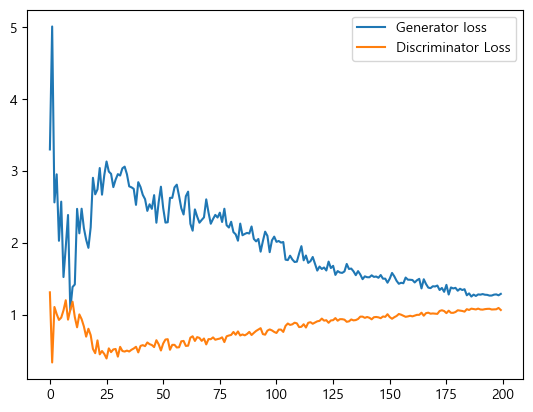

In [38]:
plt.figure()
losses_g = [fl.item() for fl in losses_g ]
plt.plot(losses_g, label='Generator loss')
losses_d = [f2.item() for f2 in losses_d ]
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()

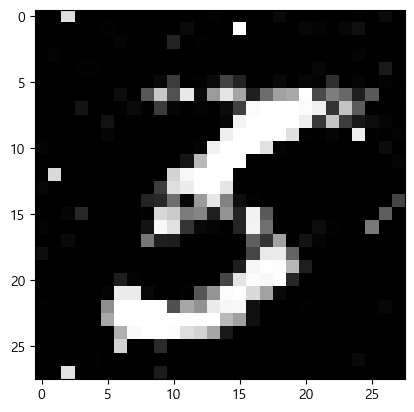

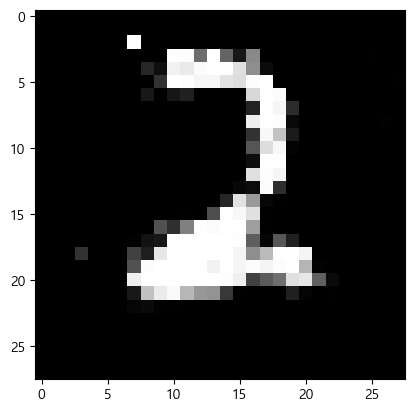

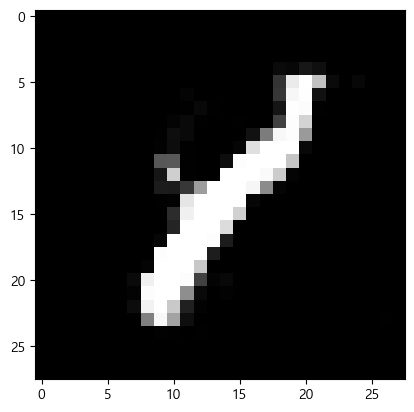

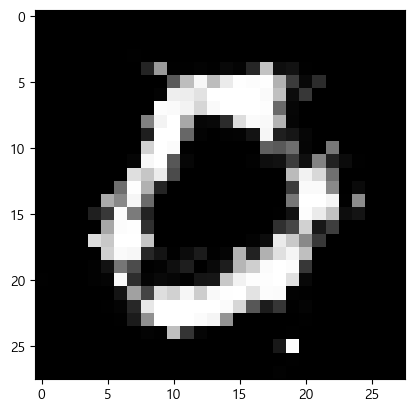

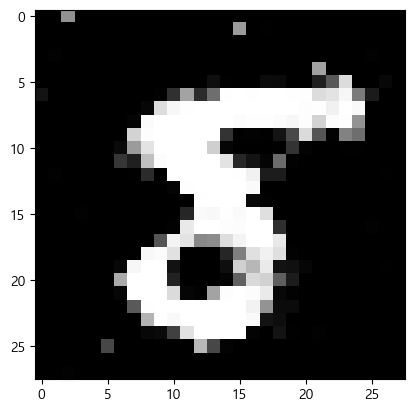

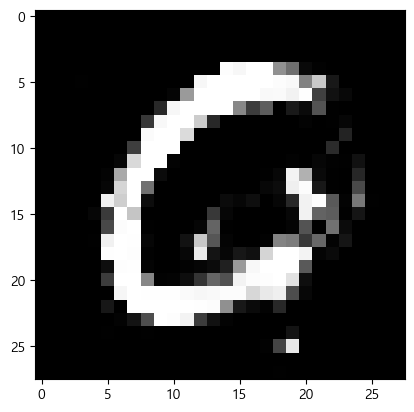

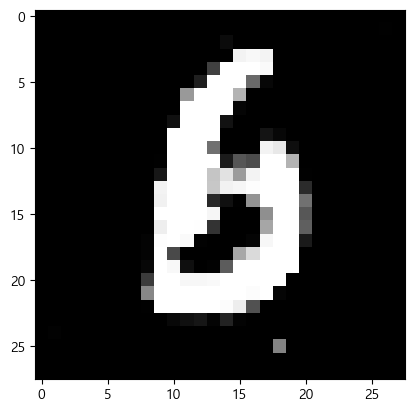

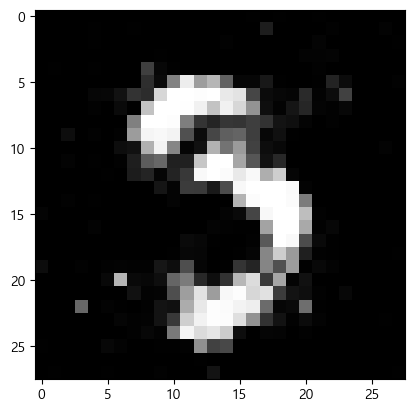

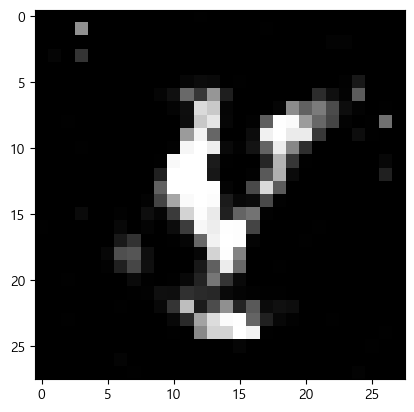

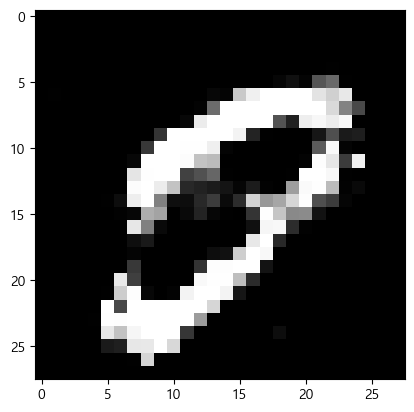

In [39]:
fake_images = generator(torch.randn(b_size, nz).to(device))
for i in range(10):
    fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i],(28, 28))
    plt.imshow(fake_images_img, cmap = 'gray')    
    plt.show()